## Importing Libraries and Loading Dataset

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import string

In [7]:
# ignore warning
import warnings
warnings.filterwarnings('ignore')

# data manipulation
import pandas as pd

# data visulization
import seaborn as sns
import matplotlib.pyplot as plt

# text processing
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from nltk.stem import PorterStemmer

# regular expression
import re

# wordcloud
from wordcloud import WordCloud
from collections import Counter

# model building and evaluation
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
from collections import Counter

In [9]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Dataset- https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
GOOGLE_DRIVE_PATH = '/content/drive/MyDrive/PersonalProjects/TwitterSentimentAnalysis'

# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'archive.zip')
# Copy it to Colab
!cp '{zip_path}' .
# Unzip it (removing useless files stored in the zip)
!yes|unzip -q archive.zip
# Delete zipped version from Colab (not from Drive)
!rm archive.zip

In [10]:
train=pd.read_csv('twitter_training.csv' ,header=None)
train=pd.DataFrame(train)
train.columns=['id','entity','sentiment','content']
train.head()

,id,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [11]:
val=pd.read_csv('twitter_validation.csv' ,header=None)
val=pd.DataFrame(val)
val.columns=['id','entity','sentiment','content']
val.head()

,id,entity,sentiment,content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [12]:
final_df = pd.concat([train,val])
final_df.head()

,id,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


## Initial Data Analysis

In [13]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75682 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         75682 non-null  int64 
 1   entity     75682 non-null  object
 2   sentiment  75682 non-null  object
 3   content    74996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.9+ MB


In [14]:
# check null values
final_df.isna().sum()

id             0
entity         0
sentiment      0
content      686
dtype: int64

In [15]:
# train.dropna(axis=0,inplace=True)
# train.reset_index(drop=True,inplace=True)
# train.isna().sum()

# drop null values
final_df.dropna(inplace=True)

In [16]:
# check duplicates values
final_df.duplicated().sum()

2857

In [17]:
# drop duplicates
final_df.drop_duplicates(inplace=True)

In [18]:
target_count = final_df.sentiment.value_counts().reset_index()
target_count

,sentiment,count
0,Negative,21790
1,Positive,19846
2,Neutral,17879
3,Irrelevant,12624


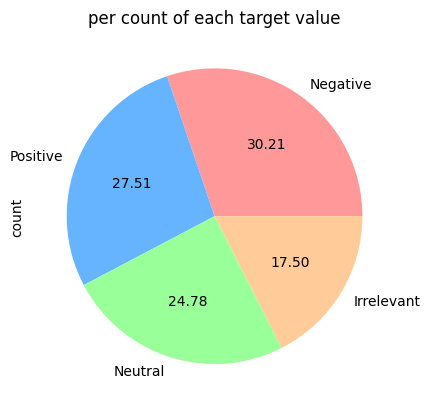

In [19]:
# value count of target col
final_df['sentiment'].value_counts().plot(kind='pie',autopct='%.2f',colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title("per count of each target value")
plt.show()

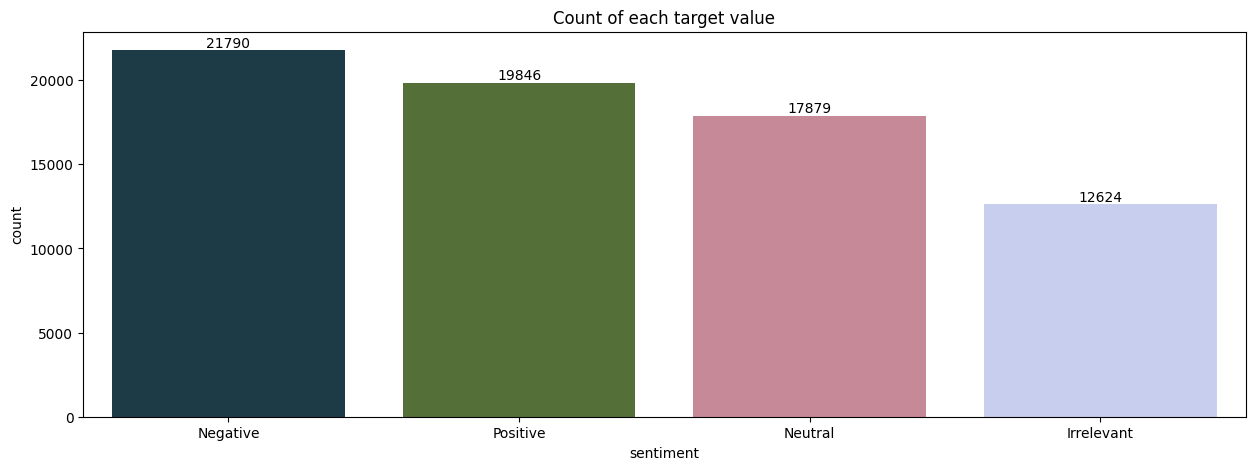

In [20]:
plt.figure(figsize=(15,5))
ax = sns.barplot(data=target_count,x='sentiment',y='count',palette='cubehelix')
for bars in ax.containers:
    ax.bar_label(bars)

plt.title("Count of each target value")
plt.show()

In [21]:
# tweet count of each user
tweet_count = final_df.groupby('id')['sentiment'].count().sort_values(ascending=False).reset_index()
tweet_count = tweet_count.rename(columns={'sentiment':'count'})
tweet_count

,id,count
0,8371,7
1,8846,7
2,2752,7
3,10429,7
4,2131,7
...,...,...
12442,4717,2
12443,5647,2
12444,5603,2
12445,3108,2


## Data Preprocessing

In [22]:
import re
import nltk

nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [23]:
# char count
final_df['char_count'] = final_df['content'].apply(len)
# word count
final_df['word_count'] = final_df['content'].apply(lambda x:len(nltk.word_tokenize(x)))
# sentence count
final_df['sent_count'] = final_df['content'].apply(lambda x:len(nltk.sent_tokenize(x)))

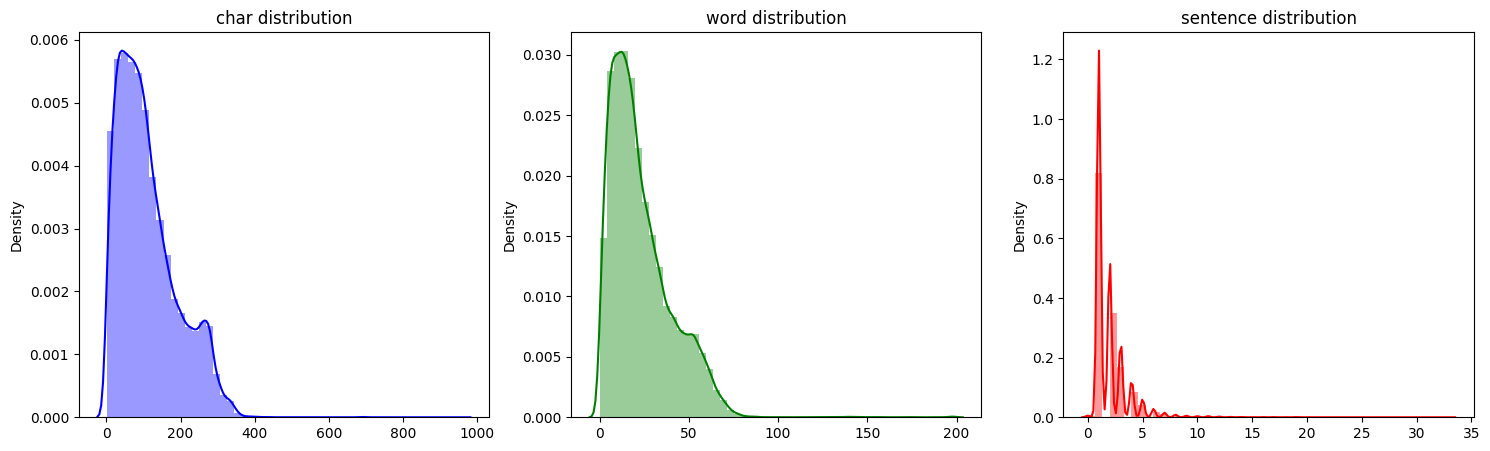

In [24]:
# dist plot

fig, axes = plt.subplots(1,3,figsize=(18,5))
sns.distplot(ax=axes[0],x=final_df['char_count'],color='b')
axes[0].set_title('char distribution')

sns.distplot(ax=axes[1],x=final_df['word_count'],color='g')
axes[1].set_title('word distribution')

sns.distplot(ax=axes[2],x=final_df['sent_count'],color='r')
axes[2].set_title('sentence distribution')
plt.show()

In [25]:
# function for text preprocessing
ps = PorterStemmer()

def preprocessing(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    full_txt = []
    for i in text:
        if i not in string.punctuation and i not in stopwords.words('english'):
            full_txt.append(ps.stem(i))
    return ' '.join(full_txt)

In [26]:
final_df['content'] = final_df['content'].apply(preprocessing)

In [27]:
final_df.head()

,id,entity,sentiment,content,char_count,word_count,sent_count
0,2401,Borderlands,Positive,im get borderland murder,53,11,1
1,2401,Borderlands,Positive,come border kill,51,13,1
2,2401,Borderlands,Positive,im get borderland kill,50,11,1
3,2401,Borderlands,Positive,im come borderland murder,51,11,1
4,2401,Borderlands,Positive,im get borderland 2 murder,57,13,1


In [28]:
final_df.duplicated().sum()

678

In [29]:
final_df = final_df.drop_duplicates()

## EDA

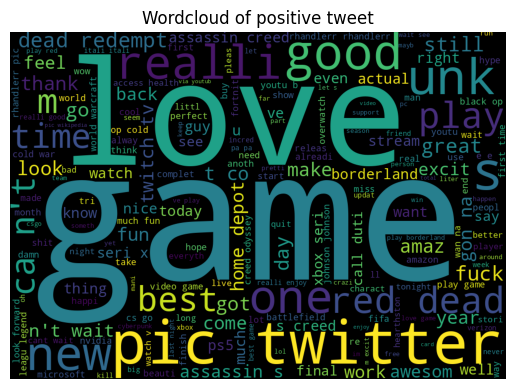

In [30]:
# word cloud for positive tweets
wc = WordCloud(width=1000,height=700,min_font_size=10,background_color='black')
positive = wc.generate(final_df[final_df['sentiment']=='Positive']['content'].str.cat(sep=" "))
plt.title('Wordcloud of positive tweet')
plt.axis('off')
plt.imshow(positive)
plt.show()

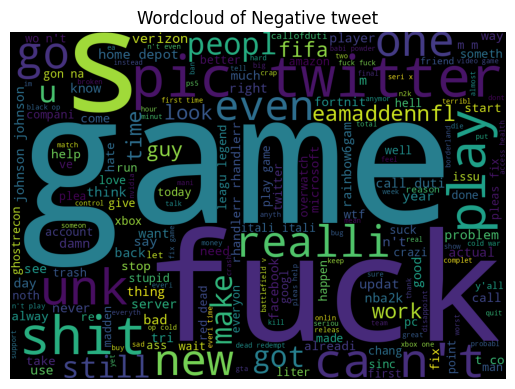

In [31]:
# word cloud for negative tweets
wc = WordCloud(width=1000,height=700,min_font_size=10,background_color='black')
negative = wc.generate(final_df[final_df['sentiment']=='Negative']['content'].str.cat(sep=" "))
plt.title('Wordcloud of Negative tweet')
plt.axis('off')
plt.imshow(negative)
plt.show()

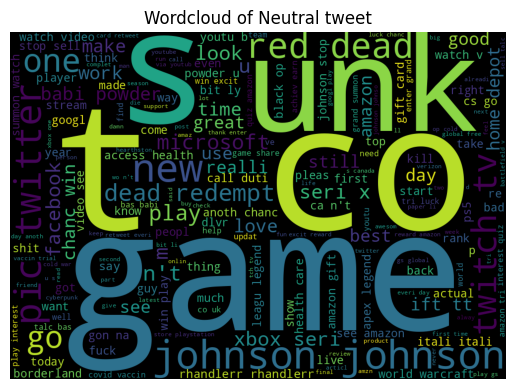

In [32]:
# word cloud for neutral tweets
wc = WordCloud(width=1000,height=700,min_font_size=10,background_color='black')
neutral = wc.generate(final_df[final_df['sentiment']=='Neutral']['content'].str.cat(sep=" "))
plt.title('Wordcloud of Neutral tweet')
plt.axis('off')
plt.imshow(neutral)
plt.show()

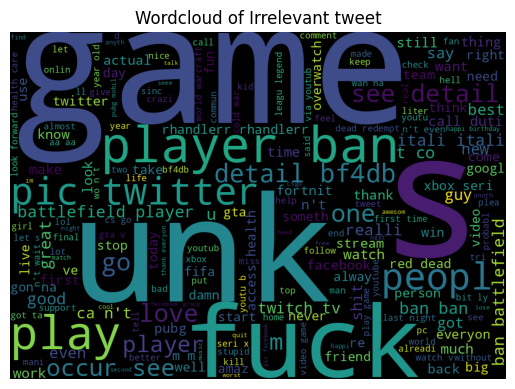

In [33]:
# word cloud for irrelevant tweets
wc = WordCloud(width=1000,height=700,min_font_size=10,background_color='black')
irrelevant = wc.generate(final_df[final_df['sentiment']=='Irrelevant']['content'].str.cat(sep=" "))
plt.title('Wordcloud of Irrelevant tweet')
plt.axis('off')
plt.imshow(irrelevant)
plt.show()

In [34]:
def pre(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text).strip()
    return text

final_df['content'] = final_df['content'].apply(pre)

In [35]:
final_df.duplicated().sum()

67

In [36]:
final_df = final_df.drop_duplicates()

In [37]:
# most common words in positive tweets
positive = []
for txt in final_df[final_df['sentiment']=='Positive']['content'].tolist():
    for word in txt.split():
        positive.append(word)

In [38]:
len(positive)

197344

<ipython-input-72-6f56795894c0>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




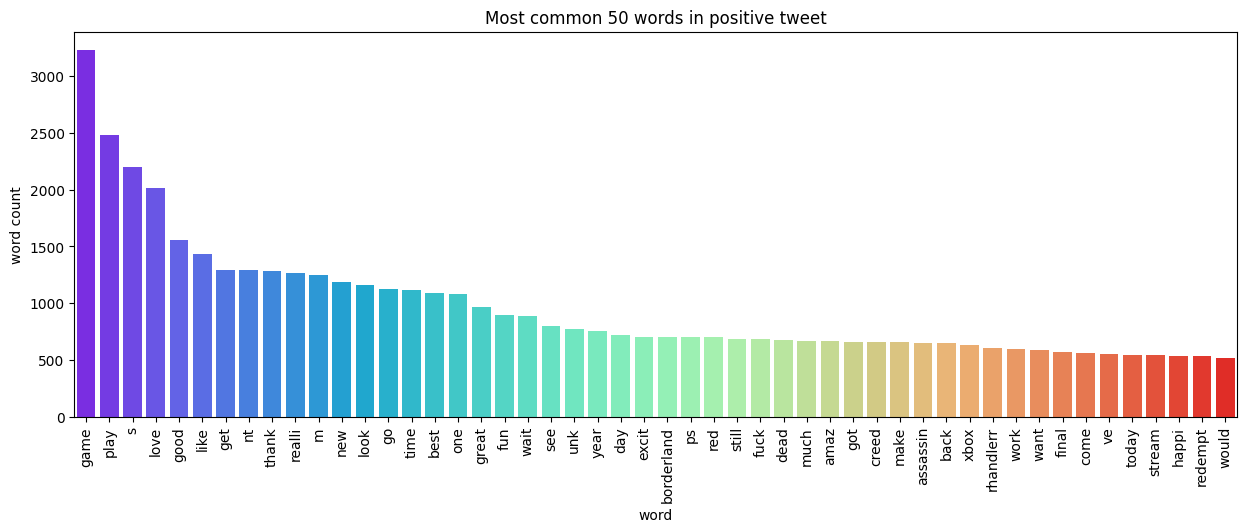

In [ ]:
# plot most 50 common words from positive tweets
plt.figure(figsize=(15,5))
sns.barplot(x=pd.DataFrame(Counter(positive).most_common(50))[0],y=pd.DataFrame(Counter(positive).most_common(50))[1],palette='rainbow')
plt.xlabel('word')
plt.ylabel('word count')
plt.title('Most common 50 words in positive tweet')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# most common words in negative tweets
negative = []
for txt in final_df[final_df['sentiment']=='Negative']['content'].tolist():
    for word in txt.split():
        negative.append(word)

In [ ]:
len(negative)

245831

<ipython-input-77-43197fc56d6b>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




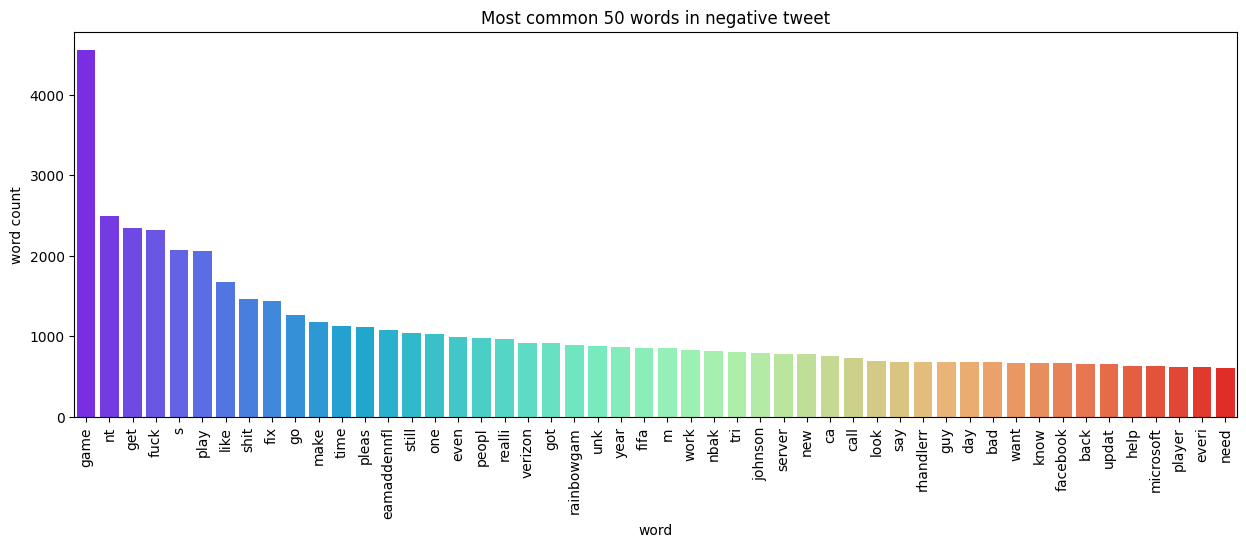

In [ ]:
# plot most 50 common words from negative tweets
plt.figure(figsize=(15,5))
sns.barplot(x=pd.DataFrame(Counter(negative).most_common(50))[0],y=pd.DataFrame(Counter(negative).most_common(50))[1],palette='rainbow')
plt.xlabel('word')
plt.ylabel('word count')
plt.title('Most common 50 words in negative tweet')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# most common words in neutral tweets
neutral = []
for txt in final_df[final_df['sentiment']=='Neutral']['content'].tolist():
    for word in txt.split():
        neutral.append(word)

In [ ]:
len(neutral)

212246

<ipython-input-81-3d6492a7233e>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




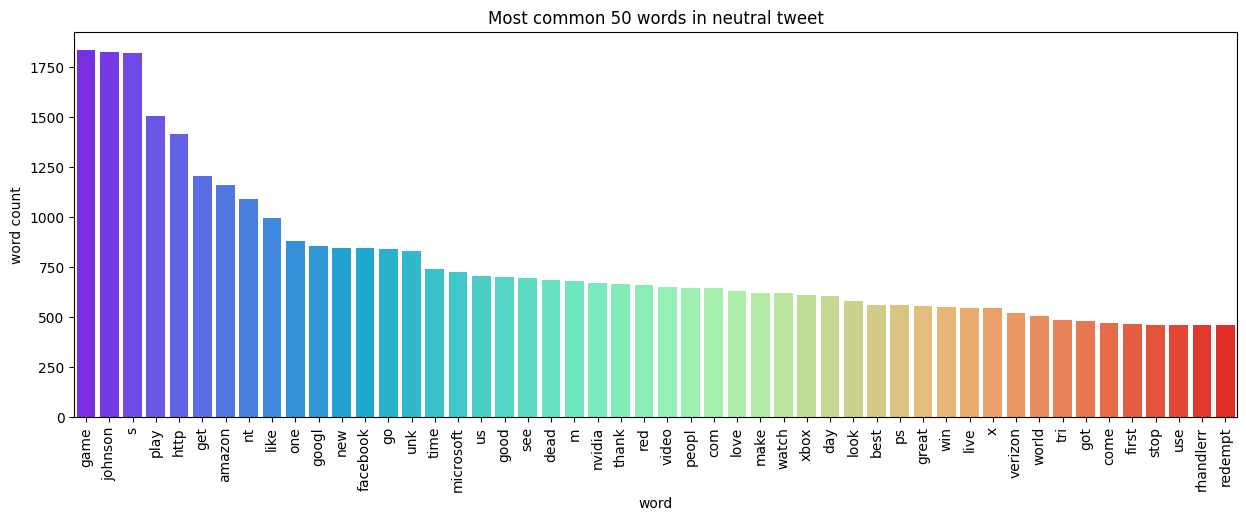

In [ ]:
# plot most 50 common words from neutral tweets
plt.figure(figsize=(15,5))
sns.barplot(x=pd.DataFrame(Counter(neutral).most_common(50))[0],y=pd.DataFrame(Counter(neutral).most_common(50))[1],palette='rainbow')
plt.xlabel('word')
plt.ylabel('word count')
plt.title('Most common 50 words in neutral tweet')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# most common words in irrelevant tweets
irrelevant = []
for txt in final_df[final_df['sentiment']=='Irrelevant']['content'].tolist():
    for word in txt.split():
        irrelevant.append(word)

In [ ]:
len(irrelevant)

139753

<ipython-input-85-c4606017ab6d>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




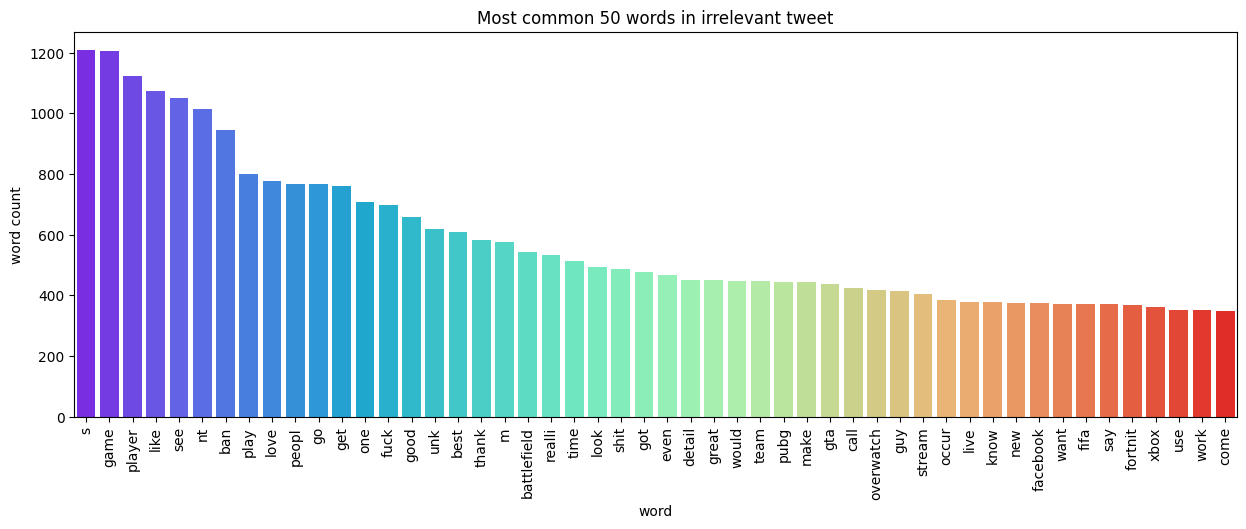

In [ ]:
# plot most 50 common words from irrelevant tweets
plt.figure(figsize=(15,5))
sns.barplot(x=pd.DataFrame(Counter(irrelevant).most_common(50))[0],y=pd.DataFrame(Counter(irrelevant).most_common(50))[1],palette='rainbow')
plt.xlabel('word')
plt.ylabel('word count')
plt.title('Most common 50 words in irrelevant tweet')
plt.xticks(rotation=90)
plt.show()

## Model

In [ ]:
#Label Encoding

# Positive - 1
# Negative - 0
# Neutral - 2
# Irrelevant - 3

final_df['target'] = final_df['sentiment'].replace({'Positive':1,'Negative':0,'Neutral':2,'Irrelevant':3})

In [ ]:
X = final_df['content']
y = final_df['target']

In [ ]:
# split the data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
# step-1 convert text data into numeric
# step-2 apply RandomForestClassifier
from sklearn.pipeline import Pipeline


sentiment_pipeline = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('rfc',RandomForestClassifier(random_state=42))
])

In [ ]:
# fit the data into pipeline
sentiment_pipeline.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('rfc', RandomForestClassifier(random_state=42))])

In [ ]:
y_pred = sentiment_pipeline.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.9051053995377828


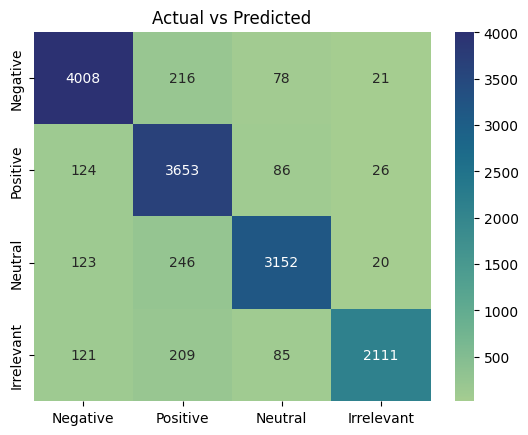

In [ ]:
# Positive - 1
# Negative - 0
# Neutral - 2
# Irrelevant - 3

label = ['Negative','Positive','Neutral','Irrelevant']
sns.heatmap(confusion_matrix(y_test,y_pred),xticklabels=label,yticklabels=label,annot=True,fmt='d',cmap='crest')
plt.title('Actual vs Predicted')
plt.show()